# TODO: Title
**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of the TODO's and/or use more than one cell to complete all the tasks.

In [ ]:
# TODO: Install any packages that you might need

In [12]:
# TODO: Import any packages that you might need
import pandas as pd
import sagemaker
import boto3
from sklearn.model_selection import train_test_split
import shutil
%matplotlib inline

## Data Preparation
**TODO:** Run the cell below to download the data.

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [16]:
import os
import json
import boto3
from tqdm import tqdm

def download_and_arrange_data():
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join('train_data', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

download_and_arrange_data()

  0%|          | 1/1228 [00:00<02:46,  7.35it/s]

  0%|          | 1/2299 [00:00<04:28,  8.57it/s]

  0%|          | 2/2666 [00:00<03:10, 13.95it/s]

  0%|          | 2/2373 [00:00<02:36, 15.11it/s]

  0%|          | 2/1875 [00:00<02:12, 14.15it/s]

100%|██████████| 1875/1875 [03:07<00:00,  9.98it/s]


In [16]:
image_dict = {1:1228,2:2299,3:2666,4:2373,5:1875}
df = pd.DataFrame.from_dict(image_dict,orient='index')
df = df.rename(columns={df.columns[0]: 'count_objects'})
print(df.head())

   count_objects
1           1228
2           2299
3           2666
4           2373
5           1875


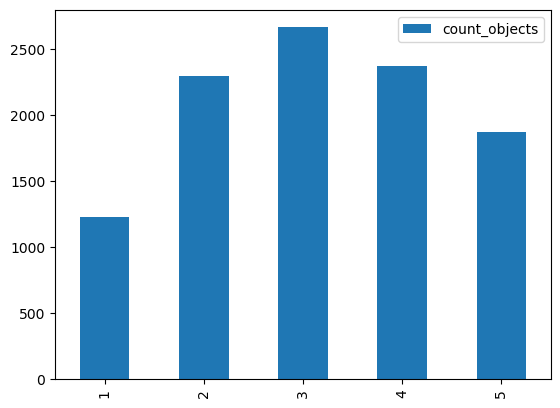

In [17]:
df.plot.bar()


## Dataset
**TODO:** Explain what dataset you are using for this project. Give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understanding of it. You can find more information about the data [here](https://registry.opendata.aws/amazon-bin-imagery/).

In [ ]:
#TODO: Perform any data cleaning or data preprocessing

In [2]:
import os 

# Get the current working directory
current_dir = os.getcwd()
print(current_dir)

/root/nd009t-capstone-starter/starter


In [23]:
##Code to separate the files into train, test split. The data is split 60% train, 20% test and 20% validation

def split_data(data_dir, test_size=0.2):
    # Get the filenames in the data directory
    filenames = os.listdir(data_dir)
    # Split the filenames into train and test sets
    X_train, X_test = train_test_split(filenames, test_size=test_size, random_state=0)
    return X_train, X_test


for i in range(1, 6):
    pth = '/root/nd009t-capstone-starter/starter/train_data/'+str(i)
    X_train, X_test = split_data(pth)
    X_train, X_val = train_test_split(X_train, test_size=0.25, random_state=0)
    train_pth = '/root/nd009t-capstone-starter/starter/train_input/'+str(i)
    test_pth = '/root/nd009t-capstone-starter/starter/test_input/'+str(i)
    val_pth = '/root/nd009t-capstone-starter/starter/val_input/'+str(i)
    for filename in X_train: 
        src_pth = os.path.join(pth, filename)
        dst_path = os.path.join(train_pth, filename)
        # Check if the destination folder exists
        if not os.path.exists(os.path.dirname(dst_path)):
            # Create the destination folder
            os.makedirs(os.path.dirname(dst_path))
        # Move the file from the source to the destination
        shutil.move(src_pth, dst_path)
    for filename in X_test: 
        src_pth = os.path.join(pth, filename)
        dst_path = os.path.join(test_pth, filename)
        # Check if the destination folder exists
        if not os.path.exists(os.path.dirname(dst_path)):
            # Create the destination folder
            os.makedirs(os.path.dirname(dst_path))
        # Move the file from the source to the destination
        shutil.move(src_pth, dst_path)
    for filename in X_val: 
        src_pth = os.path.join(pth, filename)
        dst_path = os.path.join(val_pth, filename)
        # Check if the destination folder exists
        if not os.path.exists(os.path.dirname(dst_path)):
            # Create the destination folder
            os.makedirs(os.path.dirname(dst_path))
        # Move the file from the source to the destination
        shutil.move(src_pth, dst_path)













In [47]:
#Import sagemaker details
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
prefix = 'capstone-project/'
role = sagemaker.get_execution_role()
print(bucket)

sagemaker-us-east-1-330592931683


In [45]:
# Upload the train, test and validaton data to s3
prefix_dict = {
    '/root/nd009t-capstone-starter/starter/train_input/':'capstone-project/train_input/',
    '/root/nd009t-capstone-starter/starter/test_input/':'capstone-project/test_input/',
    '/root/nd009t-capstone-starter/starter/val_input/':'capstone-project/val_input/'}

for local_dir in prefix_dict.keys(): 
    prefix = prefix_dict[local_dir]
    # Iterate through the files in the local directory and its subdirectories
    for root, dirs, files in os.walk(local_dir):
        # Iterate through the files
        for file in files:
            # Construct the full path to the file
            file_path = os.path.join(root, file)
            # Construct the S3 key (i.e., the path) for the file
            key = prefix + os.path.relpath(file_path, local_dir)
            # Upload the file to S3
            s3.upload_file(file_path, bucket, key)

## Model Training
**TODO:** This is the part where you can train a model. The type or architecture of the model you use is not important. 

**Note:** You will need to use the `train.py` script to train your model.

In [64]:
#TODO: Declare your model training hyperparameter.
#NOTE: You do not need to do hyperparameter tuning. You can use fixed hyperparameter values
#TODO: Declare your HP ranges, metrics etc.
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

hyperparameters = {
    "batch_size": 32,
    "epochs": 4,
    "lr":0.01
}

objective_metric_name = "average accuracy"
objective_type = "Maximize"
metric_definitions = [{"Name": "accuracy", "Regex": "Testing Accuracy: (?[0-9\\.]+)"}]

In [65]:
#TODO: Create your training estimator
# TODO: Create and fit an estimator
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    role=role,
    instance_count=1,
    instance_type="ml.m5.2xlarge",
    entry_point="train.py",
    framework_version="1.8",
    py_version="py36",
    hyperparameters=hyperparameters,
)

In [66]:
#Data Directories
input_data = 's3://sagemaker-us-east-1-330592931683/capstone-project'
s3_output_dir = "s3://{}/{}/{}/".format(bucket,"capstone-project", "output")
s3_model_dir = "s3://{}/{}/".format(bucket,"capstone-project", "model")

os.environ['SM_CHANNEL_TRAINING'] = input_data
os.environ['SM_MODEL_DIR'] = s3_model_dir
os.environ['SM_OUTPUT_DATA_DIR'] = s3_output_dir

In [ ]:
# TODO: Fit your estimator
estimator.fit({'train': input_data+'/train_input',       
'test': input_data+'/test_input',      
'val': input_data+'/val_input'},wait=True)

2023-01-05 20:38:28 Starting - Starting the training job...
2023-01-05 20:38:52 Starting - Preparing the instances for trainingProfilerReport-1672951108: InProgress
......
2023-01-05 20:39:52 Downloading - Downloading input data...
2023-01-05 20:40:19 Training - Downloading the training image...
2023-01-05 20:40:53 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-01-05 20:40:48,109 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-01-05 20:40:48,112 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-01-05 20:40:48,120 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-01-05 20:40:48,122 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-01-05 20:40:48,305 sagemaker-training-toolkit INFO     No GPUs 